## Домашнее задание

1. Сделать класс нейронки, вписать необходимые операции, архитектура ниже
1. Написать обучалку (обобщить то, что было выше)
1. Добавить логирование
    1. Сохранять лосс на каждой итерции обучения __0.25 балла__ ✓
    1. Каждую эпоху сохранять лосс трейна и тест __0.25 балла__ ✓
    1. Каждую эпоху рассчитывать метрики __0.25 балла__ ✓
    1. Добавить прогресс бар, в котором показывается усредненный лосс последних 500-та итераций __0.25 балла__ ✓
1. Добавить early stopping __0.5 балла__
1. Нарисовать графики лосса, метрик, конфьюжин матрицу __0.5 балла__ ✓


### Архитектура (что можно попробовать)
1. Предобученные эмбеддинги. Почитайте [здесь](https://pytorch.org/docs/stable/nn.html#embedding) (from_pretrained) как вставить свои эмбеддинги, выше мы читали матрицу эмбеддингов. __0 баллов__ ✓
1. Дообучить эмбеддинги отдельно от сети. __2 балла__
1. Дообучить эмбеддинги вместе с сетью и с другим learning rate (указывается в оптимизаторе). __2 балла__ ✓
1. Bidirectional LSTM. __1 балл__ ✓
1. Несколько параллельных CNN с разными размерами окна и mean/max over time пулингами к ним и дальнейшей конкатенацией. __2 балла__ ✓
1. Несколько последовательных CNN. __1 балла__ ✓
1. Разные окна и residual к предыдущему пункту. __2 балла__ ✓
1. Предыдущий пункт сделан без ошибок (замаскированы свертки паддингов). __2 балла__
1. Написать правильный mean/max пулинг, который не учитывает паддинги, точнее их маскирует. __2 балла__
1. Добавить [torch.nn.utils.rnn.pack_padded_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_padded_sequence) и [torch.nn.utils.rnn.pack_sequence()](https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.pack_sequence) для LSTM. Инфа [здесь](#Еще-важный-момент-про-LSTM) __2 балла__ ✓
1. Добавить spatial дропаут для входа LSTM (не просто стандартный пункт при инициализации LSTM) __1 балл__
1. Добавить BatchNorm/LayerNorm/Dropout/Residual/etc __1 балл__ ✓
1. Добавить шедуллер __1 балл__ ✓
1. Обучать на GPU __2 балла__
1. Сделать transfer learning с собственно обученной языковой модели, обученной на любых данных, например, unlabeled. __7 баллов__
1. your madness

## 10 баллов максимум

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import nn
import torch.nn.functional as F

import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

# вынес в отдельные файлы, чтобы не забивать тетрадку
from src.data import Parser
from src.utils import load_embeddings, TextClassificationDataset
from src.train import train_model

from typing import Iterable, List, Tuple

from nltk.tokenize import wordpunct_tokenize

## Читаем и обрабатываем данные

In [2]:
data_path = '/mnt/f/data/dl'

In [3]:
parser = Parser(data_path=data_path)

In [4]:
unlabeled, train, valid = parser.run()

Reading: 100%|██████████| 38/38 [01:51<00:00,  2.93s/it]


In [5]:
unique_categories = set(train.category.unique().tolist() + valid.category.unique().tolist())

In [6]:
category2index = {category: index for index, category in enumerate(unique_categories)}

In [7]:
train['target'] = train.category.map(category2index)
valid['target'] = valid.category.map(category2index)

In [8]:
vocab, embeddings = load_embeddings('/mnt/f/data/models/wiki-news-300d-1M.vec.zip', 'wiki-news-300d-1M.vec', max_words=100_000)

100%|█████████▉| 99998/100000 [00:09<00:00, 10287.32it/s]


In [9]:
train_x, train_y = train.question.tolist(), train.target.tolist()
valid_x, valid_y = valid.question.tolist(), valid.target.tolist()

In [10]:
train_ds = TextClassificationDataset(texts=train_x, targets=train_y, vocab=vocab)
valid_ds = TextClassificationDataset(texts=valid_x, targets=valid_y, vocab=vocab)

train_loader = DataLoader(train_ds, batch_size=512)
valid_loader = DataLoader(valid_ds, batch_size=512)

## Архитектура сети

In [11]:
class MyNet(nn.Module):
    
    def __init__(self,
                 embeddings: np.ndarray,
                 n_filters: int,
                 kernel_sizes: List[int],
                 n_classes: int,
                 dropout: float,
                 lstm_hidden_size: int):
        
        super().__init__()
        
        self.lstm_hidden_size = lstm_hidden_size
        
        self.embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embeddings).float(),
                                                            padding_idx=0,
                                                            freeze=False)
        
        self.embedding_dim = embeddings.shape[-1]
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=self.lstm_hidden_size * 2,
                                              out_channels=n_filters,
                                              kernel_size=ks)
                                     for ks in kernel_sizes])
        
        
        self.linear_final = nn.Linear(len(kernel_sizes) * n_filters, n_classes)
        
        self.dropout = nn.Dropout(dropout)
        
        self.batch_norm = nn.BatchNorm1d(num_features=len(kernel_sizes) * n_filters)
        
        self.residual_conv = nn.Conv1d(in_channels=self.lstm_hidden_size * 2,
                                       out_channels=len(kernel_sizes) * n_filters,
                                       kernel_size=1)
        
        self.conv_2 = nn.Conv1d(in_channels=len(kernel_sizes) * n_filters,
                                out_channels=len(kernel_sizes) * n_filters,
                                kernel_size=2)
        
        self.conv_3 = nn.Conv1d(in_channels=len(kernel_sizes) * n_filters,
                                out_channels=len(kernel_sizes) * n_filters,
                                kernel_size=3)
        
        self.avg_pool = nn.AvgPool1d(kernel_size=3,
                                     stride=1,
                                     padding=1,
                                     count_include_pad=False,
                                     ceil_mode=False)
        
        self.lstm = torch.nn.LSTM(self.embedding_dim,
                                  lstm_hidden_size,
                                  batch_first=True,
                                  bidirectional=True)
        
    @staticmethod
    def pad_convolution(x, kernel_size):
        x = F.pad(x.transpose(1, 2), (kernel_size - 1, 0))
        return x.transpose(1, 2)
    
    @staticmethod
    def count_pads(x, axis=1):
        return torch.Tensor(np.count_nonzero(x, axis=axis)) # торчовая функция почему-то не находится
        
    def forward(self, x):
        
        lengths = self.count_pads(x)
        
        x = self.embedding_layer(x)
        
        x = pack_padded_sequence(x,
                                 lengths,
                                 batch_first=True,
                                 enforce_sorted=False)
        
        x, memory = self.lstm(x)
        
        x = pad_packed_sequence(x, batch_first=True)[0]
        
        residual = self.residual_conv(x.transpose(1, 2)).transpose(1, 2)
        
        convs = [F.relu(conv(self.pad_convolution(x, conv.kernel_size[0]).transpose(1, 2)).transpose(1, 2)) for conv in self.convs]

        convs = [self.avg_pool(conv.transpose(1, 2)).transpose(1, 2) # FIX
                 for conv in convs]

        x = torch.cat(convs, 2)
        x = x + residual
        x = self.dropout(x)
        
        residual = x
        x = F.relu(self.conv_2(self.pad_convolution(x, self.conv_2.kernel_size[0]).transpose(1, 2)).transpose(1, 2))
        x = self.avg_pool(x.transpose(1, 2)).transpose(1, 2)
        x = x + residual
        
        residual = x
        x = F.relu(self.conv_3(self.pad_convolution(x, self.conv_3.kernel_size[0]).transpose(1, 2)).transpose(1, 2))
        x = x + residual

        x = x.mean(dim=1) # FIX
        
        x = self.batch_norm(x)
        
        x = self.dropout(x)
        
        return self.linear_final(x)

In [12]:
model = MyNet(embeddings=embeddings,
              n_filters=128,
              kernel_sizes=[2, 3, 4],
              n_classes=len(category2index),
              dropout=0.15,
              lstm_hidden_size=128)

In [13]:
layer_list = ['embedding_layer.weight']
params = list(map(lambda x: x[1], list(filter(lambda kv: kv[0] in layer_list, model.named_parameters()))))
base_params = list(map(lambda x: x[1], list(filter(lambda kv: kv[0] not in layer_list, model.named_parameters()))))

In [14]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([{'params': base_params}, {'params': params, 'lr': 1e-5}], lr=1e-2)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

## Обучение

In [15]:
model, losses, metrics, valid_preds, valid_targets = train_model(model,
                                                                 train_loader,
                                                                 valid_loader,
                                                                 optimizer,
                                                                 criterion,
                                                                 scheduler,
                                                                 epochs=6)

Epoch 2 of 6:   0%|          | 0/250000 [00:00<?, ?it/s]

--------------------------------------------------
Epoch 1 results
Mean train loss: 1.020, Mean valid loss: 0.912
Train accuracy: 0.654, valid accuracy: 0.693
Train weighted F1: 0.650, valid weighted F1: 0.692
--------------------------------------------------


Epoch 3 of 6:   0%|          | 0/250000 [00:00<?, ?it/s]

--------------------------------------------------
Epoch 2 results
Mean train loss: 0.818, Mean valid loss: 0.861
Train accuracy: 0.721, valid accuracy: 0.713
Train weighted F1: 0.719, valid weighted F1: 0.711
--------------------------------------------------


Epoch 4 of 6:   0%|          | 0/250000 [00:00<?, ?it/s]

--------------------------------------------------
Epoch 3 results
Mean train loss: 0.738, Mean valid loss: 0.862
Train accuracy: 0.747, valid accuracy: 0.717
Train weighted F1: 0.745, valid weighted F1: 0.717
--------------------------------------------------


Epoch 5 of 6:   0%|          | 0/250000 [00:00<?, ?it/s]

--------------------------------------------------
Epoch 4 results
Mean train loss: 0.674, Mean valid loss: 0.863
Train accuracy: 0.767, valid accuracy: 0.722
Train weighted F1: 0.765, valid weighted F1: 0.724
--------------------------------------------------


Epoch 6 of 6:   0%|          | 0/250000 [00:00<?, ?it/s]

--------------------------------------------------
Epoch 5 results
Mean train loss: 0.615, Mean valid loss: 0.909
Train accuracy: 0.787, valid accuracy: 0.717
Train weighted F1: 0.786, valid weighted F1: 0.721
--------------------------------------------------


Epoch 6 of 6: 100%|██████████| 250000/250000 [18:39<00:00, 223.25it/s, train_loss=0.557]


--------------------------------------------------
Epoch 6 results
Mean train loss: 0.558, Mean valid loss: 0.909
Train accuracy: 0.806, valid accuracy: 0.725
Train weighted F1: 0.806, valid weighted F1: 0.726
--------------------------------------------------


## Итоги

In [16]:
print(classification_report(valid_targets, valid_preds))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      2131
           1       0.59      0.62      0.61      2978
           2       0.84      0.70      0.76     10187
           3       0.61      0.82      0.70     12699
           4       0.78      0.62      0.69      4998
           5       0.84      0.83      0.84      8833
           6       0.74      0.65      0.69      4117
           7       0.72      0.57      0.64      4057

    accuracy                           0.72     50000
   macro avg       0.74      0.68      0.71     50000
weighted avg       0.74      0.72      0.73     50000



В целом результаты достаточно неплохие. Отедьные категории определяеются лучше других.

In [23]:
(train.target.value_counts() / train.shape[0]).sort_index()

0    0.042628
1    0.059560
2    0.203752
3    0.253972
4    0.099956
5    0.176656
6    0.082340
7    0.081136
Name: target, dtype: float64

In [24]:
category2index

{'grocery and gourmet food': 0,
 'baby': 1,
 'automotive': 2,
 'sports and outdoors': 3,
 'office products': 4,
 'cell phones and accessories': 5,
 'beauty': 6,
 'pet supplies': 7}

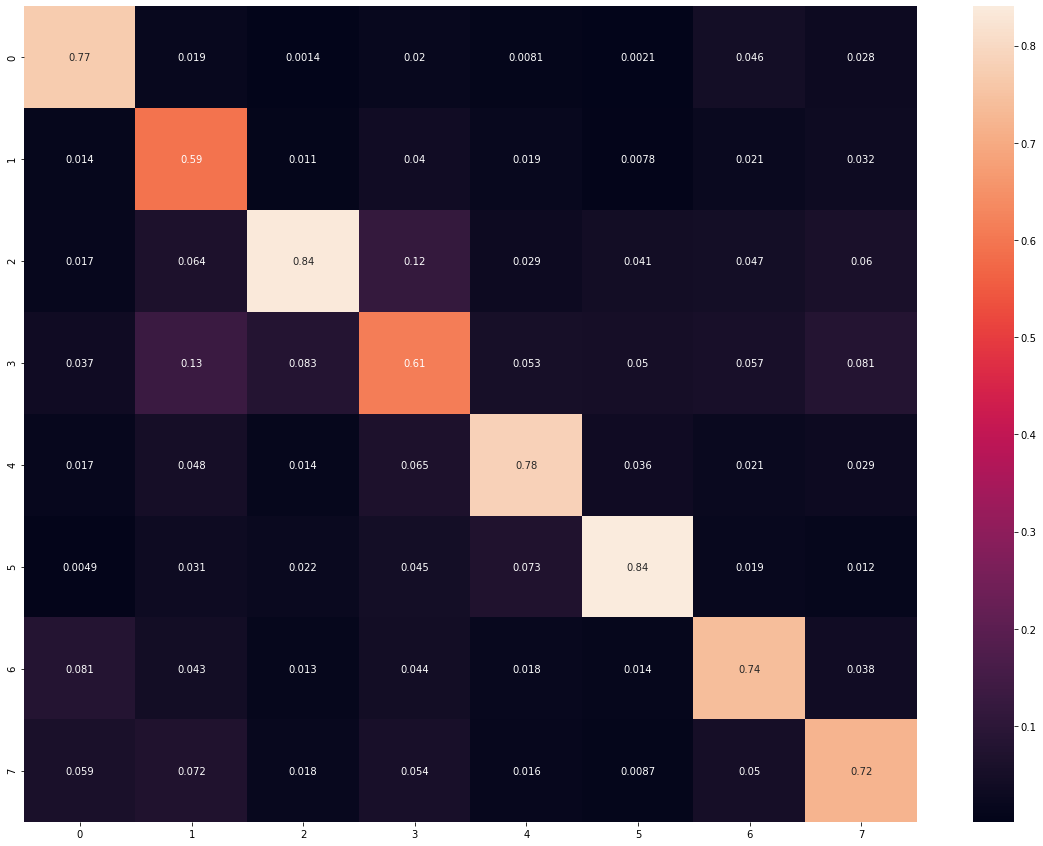

In [17]:
plt.figure(figsize=(20, 15))

cf = confusion_matrix(valid_targets, valid_preds, normalize='pred')
g = sns.heatmap(cf, annot=True)

Можем видеть, что модель сравнительно хорошо предсказывает все категории, за исключением `baby` и `sports and outdoors`, которые составляют 5 и 25 процентов датасета соответственно. Категория `sports and outdoors` чаще всего ошибочно предсказывается как `baby`, `baby` как `sports and outdoors`, т.е. модель путает между собой эти категории.

Категория `cell phones and accessories` определяется лучше всех остальных. Предполагаю, что дело в том, что описания из этих категорий меньше всего пересекаются со всеми остальными.

In [29]:
train.loc[train.target == 3].tail(3).values

array([['is size 24 a plus size true to size?',
        'i bought the henderson neosport scuba shorts in small and found the fit to be true.  a long sleeve rash guard, vest and these shorts are perfect for warm water diving.  i will buy another pair of the shorts before my next dive trip.',
        'sports and outdoors', 3],
       ['how tall are some of the riders for this bike? i am 6\'1" and ~190 pounds.',
        'i\'m 5\'7" and 185 it\'s fine for me and my buddy is 6\'4" or 5" and he can ride it no problem. make sure you get the right tube when the tire pops.',
        'sports and outdoors', 3],
       ['can it be used at tempertures below 32',
        'as long as the base is inside climatly controlled',
        'sports and outdoors', 3]], dtype=object)

In [30]:
train.loc[train.target == 1].tail(3).values

array([['will this fit the duo glider double stroller',
        "hi, for that stroller.. i wouldn't count on this shield would fit, due to how the stroller is higher for both the seats and plus the canopy. i'm already have small fitting issue with this shield on my chicco together double stroller...with and without the canopies... it was a ok fit for me.. hope this helps.",
        'baby', 1],
       ['what kind of material are the wheels? rubber or thin plastic?',
        'rubber for sure', 'baby', 1],
       ['would this bag fit 4 tommie tippie bottles? i see a lot of comments on not fitting taller bottles - wondering if the shorter bottles would fit. thanks',
        "i would say no, because i had the tall, thin playtex bottles and could only fit three. it is pretty narrow - i didn't have a problem with height but i think the tt bottles are wider than playtex. hope that helps!",
        'baby', 1]], dtype=object)

Можно предположить, что это связано с тем, что в обеих категориях есть спецификации одежды и всяких аксессуаров, поэтому модели может быть сложно отличить одно от другого.

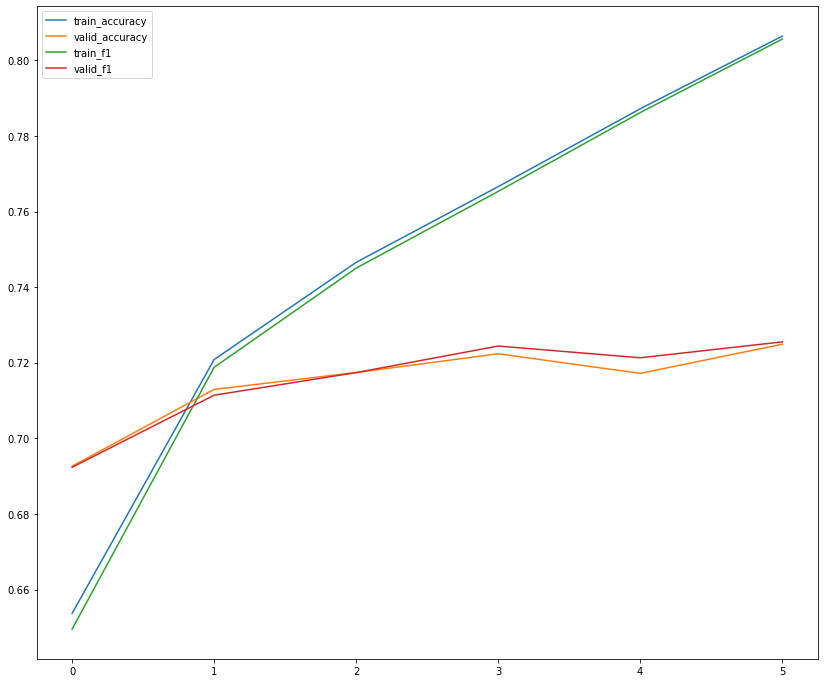

In [18]:
metrics_df = pd.DataFrame.from_dict(metrics)
g = metrics_df.plot(figsize=(14, 12))

Можно видеть, что модель практически сразу начинает переобучаться. Возможно, дело в том, что для такой сложной архитектуры у нас недостаточно данных.

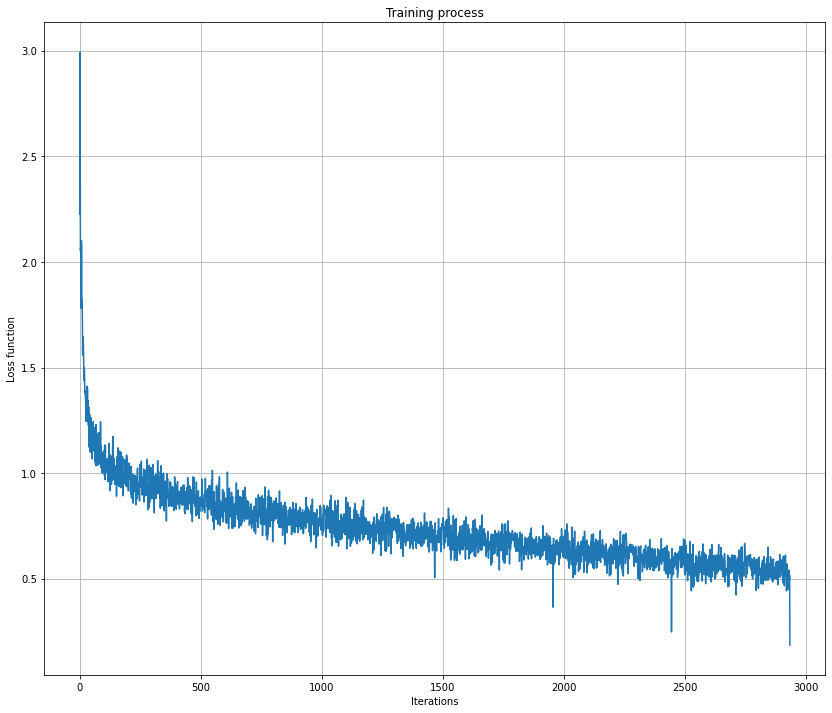

In [19]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

### Итоги

В принципе получились пункты, отмеченные галочками. Начинал сеть со слоя с паралелльными сверткам, затем добавил еще два сверточных слоя и residual связи. Потом добавил сверху двунаправленный LSTM с маскированными падами, для чего потребовалось добавить метод по подсчету нулей в последовательностях. Могу сказать, что в данном случае более сложная архитектура не привела к более высоким результатам. Лучшие результаты получались с самой простой архитектурой. Также можно отметить, что разморозка эмбеддингов и их обучение с меньшим `lr` повышает качество результатов модели. Эффекта от шедулера не заметил.

Как правильно сделать пулинг без учета паддингов длины предложения не удалось разобраться, как и добавить spatial дропаут в LSTM.